In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import awkward
import itertools
import time, sys
import matplotlib.colors
from IPython.display import clear_output
import scipy.optimize as optimization
import multiprocessing as mp
import functools
import tqdm
import scipy
from scipy.optimize import curve_fit 
from scipy.stats import norm
from scipy.signal import argrelextrema
from scipy.interpolate import make_interp_spline, CubicSpline
from sklearn.neighbors import KernelDensity

def update_progress(i, nfiles): #progress bar, just for show
    progress = i / nfiles
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "N Files to process = {0} \nProgress: [{1}] {2:.1f}%".format(nfiles, "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [2]:
base_path = '/global/cfs/cdirs/lz/data/reconstructed/SR3/LZAP-5.7.0_PROD-4/202308/'
runs = range(14297,14301) #SR3 Kr83m
#base_path = '/global/cfs/cdirs/lz/data/reconstructed/SR3/LZAP-dev-05a4c7da_PROD-0/202308/'
#runs = range(14297,14298) #SR3 Kr83m
files = []
for run in runs:
    files.extend(glob.glob(base_path + '*{0:06d}/rq/*.root'.format(run)))
#files = files[len(files)//2:]
print(len(files))

400


In [3]:
def pulsestats(thefile): #main function where we get the needed things from the RQs
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    sscatterS1 = scatters.array('ss.s1PulseID')
    sscatterS2 = scatters.array('ss.s2PulseID')
    nss = scatters.array('ss.nSingleScatters')
    s1c = scatters.array('ss.s1Area_phd')
    s2c = scatters.array('ss.s2Area_phd')
    zc = scatters.array('ss.correctedZ_cm')
    xc = scatters.array('ss.x_cm')
    yc = scatters.array('ss.y_cm')
    rc = np.sqrt(xc ** 2 + yc ** 2)
    ds1 = scatters.array('ss.isDoubleS1')
    s1a = scatters.array('ss.s1aPulseID')
    s1b = scatters.array('ss.s1bPulseID')
    startTime_us = events.array('pulsesTPC.pulseStartTime_ns') / 1000
    drift = scatters.array('ss.driftTime_ns') / 1000
    S1prob = events.array('pulsesTPC.s1Probability')
    runID = events.array('eventHeader.runID')
    eventID = events.array('eventHeader.eventID')

    goodID = nss == 1 #get all events without nan
    #startTime_us = startTime_us[goodID] #get only SS events here
    nevents = len(eventID)
    upperz = drift < 1000 
    lowerz = drift > 80
    FIDZ_ID = np.logical_and(upperz,lowerz) #fidz cut

    FIDR_ID = [] #fidR cut
    for i, r in enumerate(rc):
        if r < 62.8:
            FIDR_ID.append(i)
        else:
            FIDR_ID.append(False)
            

    isDS1 = ds1 == 1
        
    #Skin cut
    #skindome = sda <= 5
    #skinbarrel = sba <= 5
    #skinID = np.logical_and(skindome,skinbarrel)

    #OD cut
    #odID = od <= 10

    Emin = s1c > 100
    Emax = s1c < 500
    EFTID = np.logical_and(Emin,Emax)# EFT cut 

    #s2 area cut
    s2min = s2c > 420
    s2max = s2c < 10**8
    s2ID = np.logical_and(s2min,s2max)

    ID = np.logical_and.reduce([FIDZ_ID,FIDR_ID,EFTID,s2ID,isDS1]) #make a boolean mask of all the cuts

    s2c = s2c[ID] #apply it to get only the events we want
    s1c = s1c[ID]
    sscatterS1 = sscatterS1[ID]
    sscatterS2 = sscatterS2[ID]
    startTime_us = startTime_us[ID]
    drift = drift[ID]
    S1prob = S1prob[ID]
    rc = rc[ID]
    nss = nss[ID]
    s1a = s1a[ID]
    s1b = s1b[ID]
    eventID = eventID[ID]
    runID = runID[ID]

    timesep = []
    for i,j in enumerate(startTime_us):
        startTime_usA = j[s1a[i]] # get the S1 start times
        startTime_usB = j[s1b[i]]
        timesep.append(np.abs(startTime_usB - startTime_usA))

    return s1c,s2c,timesep,drift,rc,nss,eventID,runID,nevents

In [4]:
s1c = []
s2c = []
startTime_us = []
drift = []
rc = []
nss = []
eventID = []
runID = []
neventsSS = []

In [5]:
nfiles = len(files)
#for i, file in enumerate(files):
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files))) 

0it [00:00, ?it/s]

400it [01:27,  4.55it/s]


In [6]:
for i in results:
    s1c.append(i[0])
    s2c.append(i[1])
    startTime_us.append(i[2])
    drift.append(i[3])
    rc.append(i[4])
    nss.append(i[5])
    eventID.append(i[6])
    runID.append(i[7])
    neventsSS.append(i[8])

In [7]:
s1c = list(itertools.chain.from_iterable(s1c))
s2c = list(itertools.chain.from_iterable(s2c))
startTime_us = list(itertools.chain.from_iterable(startTime_us))
drift = list(itertools.chain.from_iterable(drift))
rc = list(itertools.chain.from_iterable(rc))
nss = list(itertools.chain.from_iterable(nss))
eventID = list(itertools.chain.from_iterable(eventID))
runID = list(itertools.chain.from_iterable(runID))

In [8]:
np.sum(neventsSS)

2000000

/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


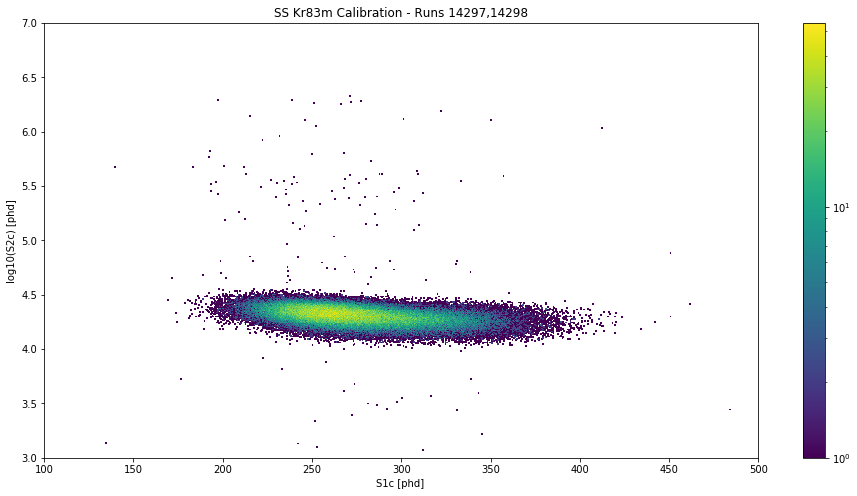

In [9]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(s1c, np.log10(s2c), bins=(1000, 1000),range =  [[0,500], [0,8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('SS Kr83m Calibration - Runs 14297,14298')
ax.set_xlabel('S1c [phd] ')
ax.set_ylabel('log10(S2c) [phd]')
plt.xlim(100,500)
plt.ylim(3,7)
plt.show()

(array([ 133.,  133.,   45.,   72.,  187.,  337.,  624.,  959., 1281.,
        1490., 1693., 1875., 2008., 2179., 2048., 1991., 1852., 1905.,
        1845., 1927., 1935., 1946., 2140., 2292., 2279., 2194., 2109.,
        2006., 1939., 1947., 1847., 1791., 1913., 1915., 1922., 1815.,
        1582., 1130.,  781.,  645.,  554.,  605.,  652.,  815., 1028.,
        1158., 1337., 1409., 1406., 1210., 1088.,  942.,  955., 1067.,
        1057., 1045., 1002.,  766.,  630.,  547.,  466.,  436.,  371.,
         300.,  281.,  335.,  445.,  604.,  448.,  311.,  307.,  293.,
         333.,  483.,  636.,  593.,  413.,  484.,  669.,  901., 1130.,
        1134.,  980.,  710.,  656.,  814.,  827.,  886.,  921.,  927.,
         825.,  910., 1244., 1634., 1687., 1544., 1679., 2176., 2848.,
        3667.]),
 array([ 80.02    ,  89.219795,  98.41959 , 107.61939 , 116.81919 ,
        126.019   , 135.2188  , 144.4186  , 153.6184  , 162.81819 ,
        172.01799 , 181.21779 , 190.41759 , 199.61739 , 208.81718 

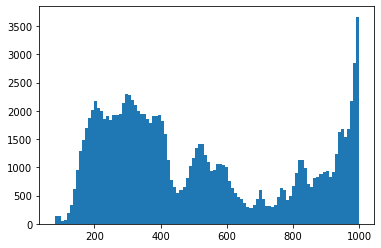

In [10]:
plt.hist(drift,bins = 100)

(array([  14.,   10.,   12.,   19.,   30.,   29.,   32.,   44.,   48.,
          51.,   67.,   65.,   55.,   72.,   72.,   76.,   68.,   90.,
         115.,   97.,  122.,  113.,  138.,  137.,  136.,  169.,  156.,
         182.,  199.,  199.,  207.,  215.,  223.,  233.,  239.,  276.,
         289.,  295.,  326.,  305.,  359.,  341.,  351.,  409.,  423.,
         418.,  483.,  473.,  475.,  491.,  532.,  516.,  522.,  565.,
         619.,  607.,  619.,  675.,  700.,  723.,  716.,  753.,  735.,
         879.,  803.,  869.,  898.,  912., 1050., 1013., 1017., 1092.,
        1115., 1177., 1267., 1344., 1434., 1471., 1587., 1600., 1743.,
        1790., 1903., 2000., 2152., 2317., 2421., 2569., 2769., 3068.,
        3484., 3785., 4167., 4562., 5136., 5681., 6240., 6962., 7670.,
        8616.]),
 array([ 0.51077676,  1.1336687 ,  1.7565604 ,  2.3794522 ,  3.0023441 ,
         3.625236  ,  4.248128  ,  4.87102   ,  5.4939117 ,  6.116803  ,
         6.739695  ,  7.362587  ,  7.985479  ,  8.608371

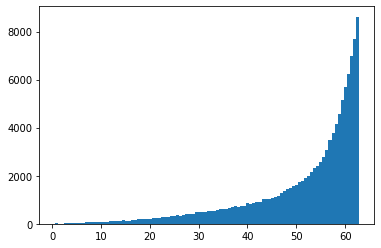

In [11]:
plt.hist(rc,bins=100)

In [12]:
myfile = open('SSKr83m_570.txt', 'w')

for i,(j,k) in enumerate(zip(runID,eventID)):
    myfile.write('%d' % j +" " + '%d' % k + '\n')
myfile.close()


In [13]:
def otherscatters(thefile):     
    #others branch is weird, so get all pulse IDs it has and remember to keep them seperate
    events = uproot.open(thefile)['Events']
    scatters = uproot.open(thefile)['Scatters']
    eventID = events.array('eventHeader.eventID')
    rawfile = events.array('eventHeader.rawFileName')
    runID = events.array('eventHeader.runID')
    otherscatterS1 = scatters.array('other.s1PulseIDs')
    otherscatterS2 = scatters.array('other.s2PulseIDs')
    nOther = scatters.array('other.nOtherScatters')
    PA = events.array('pulsesTPC.pulseArea_phd')
    xpos = events.array('pulsesTPC.s2Xposition_cm')
    ypos = events.array('pulsesTPC.s2Yposition_cm')
    r2 = np.sqrt(xpos**2 + ypos**2)
    startTime_us = events.array('pulsesTPC.pulseStartTime_ns') / 1000
    areaFrac5_us = events.array('pulsesTPC.areaFractionTime5_ns') / 1000
    pulseEdge = startTime_us + areaFrac5_us #beginning time of each pulse

    isOther = nOther > 0
    S1PID = otherscatterS1[isOther]
    S2PID = otherscatterS2[isOther]
    PA = PA[isOther]
    r2 = r2[isOther]    
    pulseEdge = pulseEdge[isOther]
    startTime_us = startTime_us[isOther]
    eventID =eventID[isOther]
    runID = runID[isOther]

    morethan1_S1 = S1PID.count() == 2
    S1PID = S1PID[morethan1_S1]
    S2PID = S2PID[morethan1_S1]
    PA = PA[morethan1_S1]
    r2 = r2[morethan1_S1]    
    pulseEdge = pulseEdge[morethan1_S1]
    startTime_us = startTime_us[morethan1_S1]
    eventID = eventID[morethan1_S1]
    runID = runID[morethan1_S1]

    OtS1area = PA[S1PID] #find the S1 and S2 areas
    OtS2area = PA[S2PID]
    OtS1area = PA[S1PID] #find the S1 and S2 areas
    OtS2area = PA[S2PID]
    S1maxID = OtS1area.argmax()
    S2maxID = OtS2area.argmax()
    S1PID = S1PID[S1maxID]
    S2PID = S2PID[S2maxID]
    OtS1area = OtS1area[S1maxID]
    OtS2area = OtS2area[S2maxID]


    S1b4S2 = []
    for i,j in zip(S1PID,S2PID): #make a mask for only the events that have the largest S1 before largest S2
        if i < j:
            S1b4S2.append(True)
        else:
            S1b4S2.append(False)
    OtS1area = OtS1area[S1b4S2]
    OtS2area = OtS2area[S1b4S2]
    S1PID = S1PID[S1b4S2]
    S2PID = S2PID[S1b4S2]
    r2 = r2[S1b4S2] 
    pulseEdge = pulseEdge[S1b4S2]
    startTime_us = startTime_us[S1b4S2]
    S1pulseEdge = pulseEdge[S1PID]
    S2pulseEdge = pulseEdge[S2PID]
    startTime_us = startTime_us[S1PID]
    r2 = r2[S2PID] #take only r positions that correlate to the largest S2
    eventID = eventID[S1b4S2]
    runID = runID[S1b4S2]
    

    drift = np.abs(S1pulseEdge - S2pulseEdge) #find drift time
    upperz = drift < 1000 
    lowerz = drift > 80
    fidz = upperz * lowerz
    flatz = fidz.flatten()
    fidz = np.logical_and(upperz,lowerz) #fidz cut
    r2 = r2[fidz]
    startTime_us = startTime_us[fidz]
    OtS1area = OtS1area[fidz]
    OtS2area = OtS2area[fidz]
    S1PID = S1PID[fidz]
    S2PID = S2PID[fidz]
    drift = drift[fidz]
    eventID = eventID[flatz]
    runID = runID[flatz]

    fidr = r2 < 62.8 # fidr cut
    OtS1area = OtS1area[fidr]
    OtS2area = OtS2area[fidr]
    S1PID = S1PID[fidr]
    S2PID = S2PID[fidr]
    flatr = fidr.flatten()
    startTime_us = startTime_us[fidr]
    r2 = r2[fidr]
    drift = drift[fidr]
    eventID = eventID[flatr]
    runID = runID[flatr]

    Emin = OtS1area > 100
    Emax = OtS1area < 500
    EFT = np.logical_and(Emin,Emax) # EFT cut
    OtS1area = OtS1area[EFT]
    OtS2area = OtS2area[EFT]
    S1PID = S1PID[EFT]
    S2PID = S2PID[EFT]
    flatEFT = EFT.flatten()
    startTime_us = startTime_us[EFT]
    r2 = r2[EFT]
    drift = drift[EFT]
    eventID = eventID[flatEFT]
    runID = runID[flatEFT]

    s2min = OtS2area > 420
    s2max = OtS2area < 10**8
    S2ID = np.logical_and(s2min,s2max)# EFT cut
    OtS1area = OtS1area[S2ID]
    OtS2area = OtS2area[S2ID]
    S1PID = S1PID[S2ID]
    S2PID = S2PID[S2ID]
    startTime_us = startTime_us[S2ID]
    flats2 = S2ID.flatten()
    r2 = r2[S2ID]
    drift = drift[S2ID]
    eventID = eventID[flats2]
    runID = runID[flats2]

    empty = [] 
    for i in OtS1area: #make sure there are no empty arrays
        if i.size < 1:
            empty.append(False)
        else:
            empty.append(True)
            
    OtS1area = OtS1area[empty]
    OtS2area = OtS2area[empty]
    S1PID = S1PID[empty]
    S2PID = S2PID[empty]
    startTime_us = startTime_us[empty]
    r2 = r2[empty]
    drift = drift[empty]
    timesep = np.diff(startTime_us)

    return OtS1area,OtS2area,timesep,drift,r2,eventID,runID

In [14]:
OtS1area = []
OtS2area = []
startTime_usO = []
driftO = []
rcO = []
runIDO = []
eventIDO = []


In [15]:
nfiles = len(files)
#for i, file in enumerate(files):
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(otherscatters),files))) 

0it [00:00, ?it/s]/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWa

In [16]:
for i in results:
    OtS1area.append(i[0])
    OtS2area.append(i[1])
    startTime_usO.append(i[2])
    driftO.append(i[3])
    rcO.append(i[4])
    eventIDO.append(i[5])
    runIDO.append(i[6])

In [17]:
OtS1area = list(itertools.chain.from_iterable(OtS1area))
OtS2area = list(itertools.chain.from_iterable(OtS2area))
startTime_usO = list(itertools.chain.from_iterable(startTime_usO))
driftO = list(itertools.chain.from_iterable(driftO))
rcO = list(itertools.chain.from_iterable(rcO))
OtS1area = list(itertools.chain.from_iterable(OtS1area))
OtS2area = list(itertools.chain.from_iterable(OtS2area))
startTime_usO = list(itertools.chain.from_iterable(startTime_usO))
driftO = list(itertools.chain.from_iterable(driftO))
rcO = list(itertools.chain.from_iterable(rcO))
runIDO = list(itertools.chain.from_iterable(runIDO))
eventIDO = list(itertools.chain.from_iterable(eventIDO))

In [18]:
print(len(OtS1area))

3893


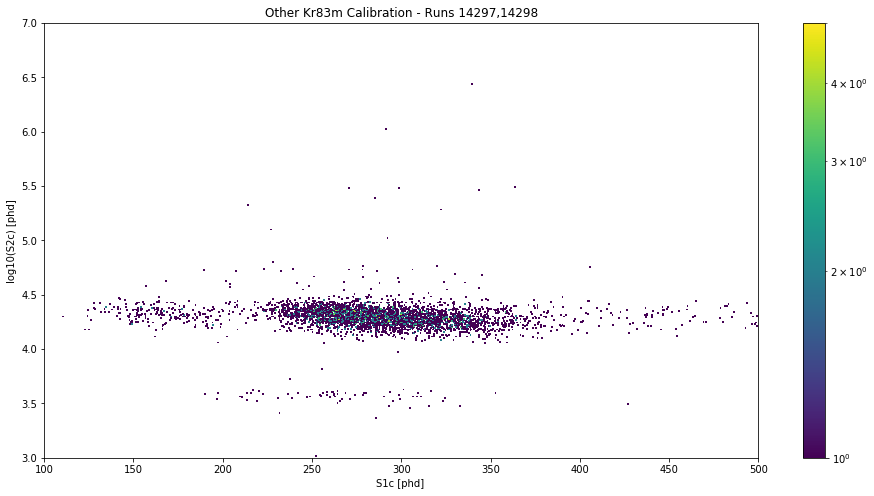

In [19]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
plt.hist2d(OtS1area, np.log10(OtS2area), bins=(1000, 1000),range =  [[0,500], [0,8]], cmin=1,norm=matplotlib.colors.LogNorm())#norm=matplotlib.colors.LogNorm()
plt.colorbar()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title('Other Kr83m Calibration - Runs 14297,14298')
ax.set_xlabel('S1c [phd] ')
ax.set_ylabel('log10(S2c) [phd]')
plt.xlim(100,500)
plt.ylim(3,7)
plt.show()

(array([ 13.,  14.,  10.,  11.,   8.,  12.,  22.,  15.,  36.,  32.,  26.,
         34.,  64.,  46.,  55.,  44.,  41.,  47.,  47.,  59.,  67.,  57.,
         62.,  57.,  61.,  59.,  33.,  55.,  49.,  40.,  55.,  41.,  45.,
         59.,  59.,  53.,  39.,  30.,  24.,  21.,  11.,  23.,  20.,  43.,
         25.,  33.,  35.,  43.,  52.,  39.,  41.,  32.,  42.,  45.,  41.,
         46.,  36.,  37.,  26.,  26.,  28.,  17.,  23.,  19.,  14.,  16.,
         22.,  20.,  16.,  17.,  13.,  20.,  23.,  21.,  34.,  23.,  27.,
         30.,  31.,  35.,  35.,  45.,  28.,  29.,  39.,  34.,  43.,  40.,
         33.,  43.,  54.,  45.,  53.,  56.,  64.,  61.,  87.,  75., 134.,
        148.]),
 array([ 81.66   ,  90.84333, 100.02666, 109.20999, 118.39332, 127.57665,
        136.75998, 145.94331, 155.12664, 164.30997, 173.4933 , 182.67663,
        191.85996, 201.04329, 210.22662, 219.40995, 228.59328, 237.77661,
        246.95994, 256.14327, 265.3266 , 274.50993, 283.69326, 292.87659,
        302.05992, 311

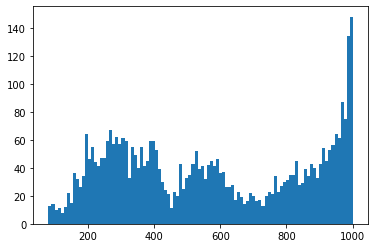

In [20]:
plt.hist(driftO,bins = 100)

(array([  2.,   1.,   0.,   0.,   0.,   2.,   3.,   2.,   1.,   1.,   1.,
          0.,   2.,   1.,   0.,   3.,   3.,   1.,   1.,   3.,   5.,   1.,
          3.,   2.,   5.,   4.,   5.,   4.,   3.,   4.,   3.,   3.,   4.,
         10.,   7.,   6.,   6.,  14.,   9.,   7.,  10.,   5.,  12.,   9.,
         11.,  12.,  11.,  17.,   6.,  17.,  11.,  15.,  12.,  16.,   7.,
          9.,  11.,  20.,  21.,  17.,  22.,  11.,  24.,  18.,  17.,  27.,
         21.,  21.,  27.,  32.,  27.,  34.,  36.,  42.,  38.,  35.,  52.,
         34.,  46.,  78.,  51.,  49.,  71.,  71.,  59.,  68.,  78.,  84.,
         89., 104., 119., 112., 136., 149., 182., 218., 239., 279., 345.,
        367.]),
 array([ 1.0249037,  1.6426476,  2.2603917,  2.8781357,  3.4958797,
         4.1136236,  4.7313676,  5.3491116,  5.9668555,  6.5845995,
         7.2023435,  7.8200874,  8.437831 ,  9.055575 ,  9.673319 ,
        10.291063 , 10.908807 , 11.526551 , 12.144295 , 12.762039 ,
        13.379784 , 13.997527 , 14.615272 , 15

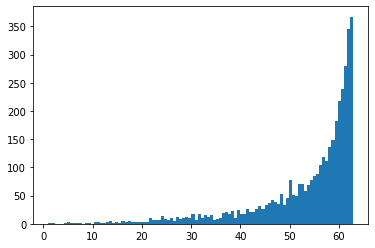

In [21]:
plt.hist(rcO,bins=100)

In [22]:
for i,(j,k) in enumerate(zip(OtS1area,np.log10(OtS2area))):
    if j > 250 and j > 300:
        print (runIDO[i],eventIDO[i])

14297 477554
14297 477575
14297 477747
14297 478050
14297 478284
14297 478829
14297 479434
14297 479910
14297 479976
14297 461047
14297 461798
14297 462038
14297 462450
14297 462554
14297 463703
14297 464140
14297 464410
14297 464624
14297 101324
14297 103166
14297 103869
14297 104984
14297 66738
14297 245572
14297 246702
14297 248083
14297 248848
14297 249591
14297 249759
14297 135664
14297 136431
14297 138371
14297 139672
14297 139840
14297 321012
14297 321272
14297 322559
14297 324006
14297 324030
14297 324197
14297 324609
14297 324815
14297 324859
14297 200057
14297 200508
14297 202023
14297 204003
14297 190112
14297 190255
14297 190366
14297 191287
14297 191510
14297 194173
14297 194486
14297 120533
14297 121345
14297 123610
14297 124636
14297 355055
14297 355375
14297 355876
14297 357453
14297 357973
14297 358152
14297 358993
14297 359400
14297 359487
14297 280310
14297 280510
14297 282619
14297 283050
14297 284041
14297 284718
14297 331484
14297 331688
14297 332671
14297 332793


## now do the old data analysis

In [23]:
#base_path = '/global/cfs/cdirs/lz/data/reconstructed/SR3/LZAP-5.5.3_PROD-1/202308/'
#runs = range(14297,14298) #SR3 Kr83m
base_path = '/global/cfs/cdirs/lz/data/reconstructed/SR3/LZAP-5.8.0_PROD-0/202308/'
runs = range(14297,14301) #SR3 Kr83m
files = []
for run in runs:
    files.extend(glob.glob(base_path + '*{0:06d}/rq/*.root'.format(run)))
print(len(files))

400


In [24]:
s1c_dev = []
s2c_dev = []
startTime_us_dev = []
drift_dev = []
rc_dev = []
nss_dev = []
eventID_dev = []
runID_dev = []
neventsSS_dev = []

In [25]:
nfiles = len(files)
#for i, file in enumerate(files):
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(pulsestats),files))) 

400it [01:28,  4.54it/s]


In [26]:
for i in results:
    s1c_dev.append(i[0])
    s2c_dev.append(i[1])
    startTime_us_dev.append(i[2])
    drift_dev.append(i[3])
    rc_dev.append(i[4])
    nss_dev.append(i[5])
    eventID_dev.append(i[6])
    runID_dev.append(i[7])
    neventsSS_dev.append(i[8])

In [27]:
s1c_dev = list(itertools.chain.from_iterable(s1c_dev))
s2c_dev = list(itertools.chain.from_iterable(s2c_dev))
startTime_us_dev = list(itertools.chain.from_iterable(startTime_us_dev))
drift_dev = list(itertools.chain.from_iterable(drift_dev))
rc_dev = list(itertools.chain.from_iterable(rc_dev))
nss_dev = list(itertools.chain.from_iterable(nss_dev))
eventID_dev = list(itertools.chain.from_iterable(eventID_dev))
runID_dev = list(itertools.chain.from_iterable(runID_dev))

In [28]:
np.sum(neventsSS_dev)

2000000

In [29]:
OtS1area_dev = []
OtS2area_dev = []
startTime_usO_dev = []
driftO_dev = []
rcO_dev = []
runIDO_dev = []
eventIDO_dev = []


In [30]:
nfiles = len(files)
#for i, file in enumerate(files):
with mp.Pool(16) as pool:
    results = list(tqdm.tqdm(pool.imap(functools.partial(otherscatters),files))) 

0it [00:00, ?it/s]/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
1it [00:03,  3.89s/it]/global/homes/m/mrw7816/miniconda3/envs/fast_lz/lib/python3.6/site-packages/ipykernel_launche

In [31]:
for i in results:
    OtS1area_dev.append(i[0])
    OtS2area_dev.append(i[1])
    startTime_usO_dev.append(i[2])
    driftO_dev.append(i[3])
    rcO_dev.append(i[4])
    eventIDO_dev.append(i[5])
    runIDO_dev.append(i[6])

In [32]:
OtS1area_dev = list(itertools.chain.from_iterable(OtS1area_dev))
OtS2area_dev = list(itertools.chain.from_iterable(OtS2area_dev))
startTime_usO_dev = list(itertools.chain.from_iterable(startTime_usO_dev))
driftO_dev = list(itertools.chain.from_iterable(driftO_dev))
rcO_dev = list(itertools.chain.from_iterable(rcO_dev))
OtS1area_dev = list(itertools.chain.from_iterable(OtS1area_dev))
OtS2area_dev = list(itertools.chain.from_iterable(OtS2area_dev))
startTime_usO_dev = list(itertools.chain.from_iterable(startTime_usO_dev))
driftO_dev = list(itertools.chain.from_iterable(driftO_dev))
rcO_dev = list(itertools.chain.from_iterable(rcO_dev))
runIDO_dev = list(itertools.chain.from_iterable(runIDO_dev))
eventIDO_dev = list(itertools.chain.from_iterable(eventIDO_dev))

In [33]:
myfile = open('SSKr83m_580.txt', 'w')

for i,(j,k) in enumerate(zip(runID_dev,eventID_dev)):
    myfile.write('%d' % j +" " + '%d' % k + '\n')
myfile.close()


#now just make the plots with both datasets

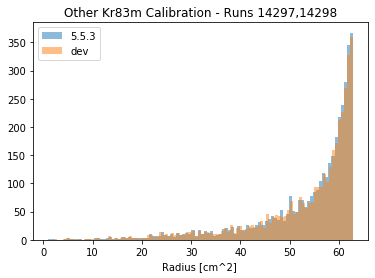

In [34]:
plt.hist(rcO,bins=100, alpha = 0.5,label = "5.5.3")
plt.hist(rcO_dev,bins=100, alpha = 0.5,label = "dev")
plt.title('Other Kr83m Calibration - Runs 14297,14298')
plt.xlabel('Radius [cm^2] ')
plt.legend()

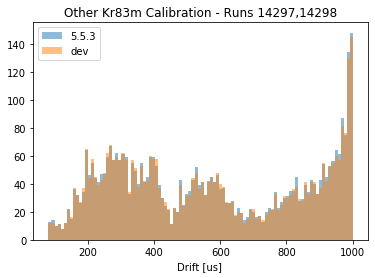

In [35]:
plt.hist(driftO,bins = 100, alpha = 0.5,label = "5.5.3")
plt.hist(driftO_dev,bins = 100, alpha = 0.5,label = "dev")
plt.title('Other Kr83m Calibration - Runs 14297,14298')
plt.xlabel('Drift [us] ')
plt.legend()

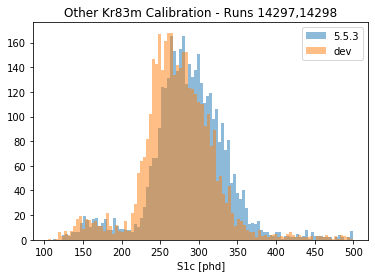

In [36]:
plt.hist(OtS1area,bins = 100, alpha = 0.5,label = "5.5.3")
plt.hist(OtS1area_dev,bins = 100, alpha = 0.5,label = "dev")
plt.title('Other Kr83m Calibration - Runs 14297,14298')
plt.xlabel('S1c [phd]')
plt.legend()

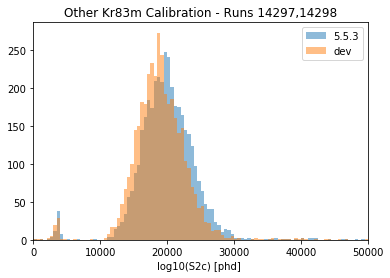

In [37]:
plt.hist(OtS2area,bins = 100,range=[0,50000], alpha = 0.5,label = "5.5.3")
plt.hist(OtS2area_dev,bins = 100,range=[0,50000], alpha = 0.5,label = "dev")
plt.xlim(0,50000)
plt.title('Other Kr83m Calibration - Runs 14297,14298')
plt.xlabel('log10(S2c) [phd] ')
plt.legend()

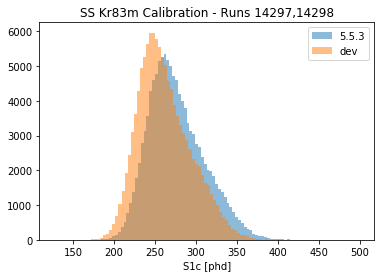

In [38]:
plt.hist(s1c,bins = 100, alpha = 0.5,label = "5.5.3")
plt.hist(s1c_dev,bins = 100, alpha = 0.5,label = "dev")
plt.title('SS Kr83m Calibration - Runs 14297,14298')
plt.xlabel('S1c [phd]')
plt.legend()

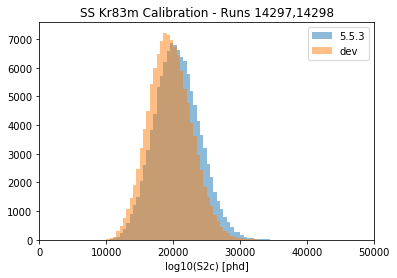

In [39]:
plt.hist(s2c,bins = 100,range=[0,50000], alpha = 0.5,label = "5.5.3")
plt.hist(s2c_dev,bins = 100,range=[0,50000], alpha = 0.5,label = "dev")
plt.xlim(0,50000)
plt.title('SS Kr83m Calibration - Runs 14297,14298')
plt.xlabel('log10(S2c) [phd]')
plt.legend()

In [40]:
print(len(s2c_dev))
print(len(s2c))

116228
116293


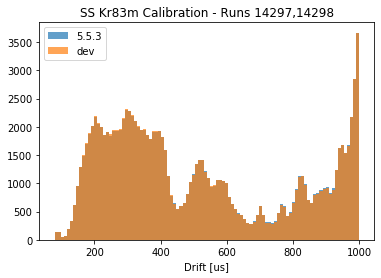

In [41]:
plt.hist(drift,bins = 100, alpha = 0.7,label = "5.5.3")
plt.hist(drift_dev,bins = 100, alpha = 0.7,label = "dev")
plt.title('SS Kr83m Calibration - Runs 14297,14298')
plt.xlabel('Drift [us]')
plt.legend()

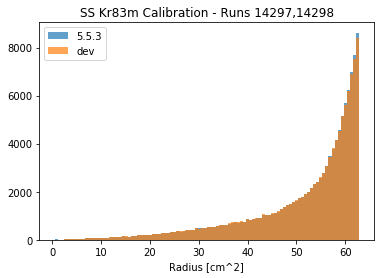

In [42]:
plt.hist(rc,bins = 100, alpha = 0.7,label = "5.5.3")
plt.hist(rc_dev,bins = 100, alpha = 0.7,label = "dev")
plt.title('SS Kr83m Calibration - Runs 14297,14298')
plt.xlabel('Radius [cm^2]')
plt.legend()

In [44]:
def read_rows_from_file(filename):
    rows = set()
    with open(filename, 'r') as file:
        for line in file:
            rows.add(line.strip())  # Store entire rows
    return rows

def find_different_rows(file1_rows, file2_rows):
    different_in_file1 = file1_rows - file2_rows
    different_in_file2 = file2_rows - file1_rows
    return different_in_file1, different_in_file2


file1 = 'SSKr83m_580.txt'
file2 = 'SSKr83m_570.txt'

# Read rows from both files
file1_rows = read_rows_from_file(file1)
file2_rows = read_rows_from_file(file2)

# Find different rows
different_in_file1, different_in_file2 = find_different_rows(file1_rows, file2_rows)

print("Rows different in", file1, "but not in", file2, ":")
for row in different_in_file1:
    print(row)

print("\nRows different in", file2, "but not in", file1, ":")
for row in different_in_file2:
    print(row)

Rows different in SSKr83m_580.txt but not in SSKr83m_570.txt :
14300 86765
14300 266972
14298 59562
14299 109398
14299 360327
14298 311926
14297 138299
14298 497039
14297 465967
14299 39107
14297 437208
14298 56037
14300 140937
14297 235078
14299 92250
14298 35948
14300 465147
14299 83572
14299 378805
14300 363325
14299 109910
14297 472546
14299 6822
14300 186718
14298 497205
14298 177341
14298 84506
14299 166929
14300 255450
14298 151483
14300 432459
14299 59614
14299 58397
14298 81358
14300 15541
14299 42837
14298 445617
14299 57720
14299 254887
14298 1662
14299 233192
14299 397859
14299 126338
14297 399135
14299 327261
14298 316810
14300 291258
14298 406926
14298 130408
14297 282160
14299 341011
14298 195336
14297 412441
14298 299404
14298 54891
14298 282778
14299 27724
14299 103821
14298 103989
14298 269821
14300 229741
14297 416419
14298 209215
14297 356695
14300 203853
14298 306582
14299 496403
14298 227934
14299 49903
14299 261017
14297 403176
14300 176473
14300 484577
14300 891

In [45]:
def read_rows_from_file(filename):
    rows = set()
    with open(filename, 'r') as file:
        for line in file:
            rows.add(line.strip())  # Store entire rows
    return rows

def find_missing_rows(source_rows, target_rows):
    missing_rows = source_rows - target_rows
    return missing_rows

file1 = 'SSKr83m_580.txt'
file2 = 'SSKr83m_570.txt'

# Read rows from both files
file1_rows = read_rows_from_file(file1)
file2_rows = read_rows_from_file(file2)

# Find missing rows in file2 compared to file1
missing_in_file2 = find_missing_rows(file1_rows, file2_rows)

# Find missing rows in file1 compared to file2
missing_in_file1 = find_missing_rows(file2_rows, file1_rows)

print("Rows missing in", file2, "compared to", file1, ":")
for row in missing_in_file2:
    print(row)

print("\nRows missing in", file1, "compared to", file2, ":")
for row in missing_in_file1:
    print(row)

Rows missing in SSKr83m_570.txt compared to SSKr83m_580.txt :
14300 86765
14300 266972
14298 59562
14299 109398
14299 360327
14298 311926
14297 138299
14298 497039
14297 465967
14299 39107
14297 437208
14298 56037
14300 140937
14297 235078
14299 92250
14298 35948
14300 465147
14299 83572
14299 378805
14300 363325
14299 109910
14297 472546
14299 6822
14300 186718
14298 497205
14298 177341
14298 84506
14299 166929
14300 255450
14298 151483
14300 432459
14299 59614
14299 58397
14298 81358
14300 15541
14299 42837
14298 445617
14299 57720
14299 254887
14298 1662
14299 233192
14299 397859
14299 126338
14297 399135
14299 327261
14298 316810
14300 291258
14298 406926
14298 130408
14297 282160
14299 341011
14298 195336
14297 412441
14298 299404
14298 54891
14298 282778
14299 27724
14299 103821
14298 103989
14298 269821
14300 229741
14297 416419
14298 209215
14297 356695
14300 203853
14298 306582
14299 496403
14298 227934
14299 49903
14299 261017
14297 403176
14300 176473
14300 484577
14300 8919